In [1]:
import importlib_resources
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import *
from scipy.stats import *
from dtuimldmtools import *
import pandas as pd
from sklearn.feature_extraction.text import *
from nltk.stem import *
import scipy.linalg as linalg
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd 
import math
from sympy import *

In [6]:
test_data = pd.read_csv("./test.csv")
training_data = pd.read_csv("./train.csv")

display(training_data.head())
display(test_data.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
columns = training_data.columns
print(columns)
print(len(columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
12


### Remove useless columns


In [28]:
refined_training_data = training_data.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
refined_training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [21]:
training_data[columns[3]]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

12


TypeError: 'value' must be an instance of str or bytes, not a float

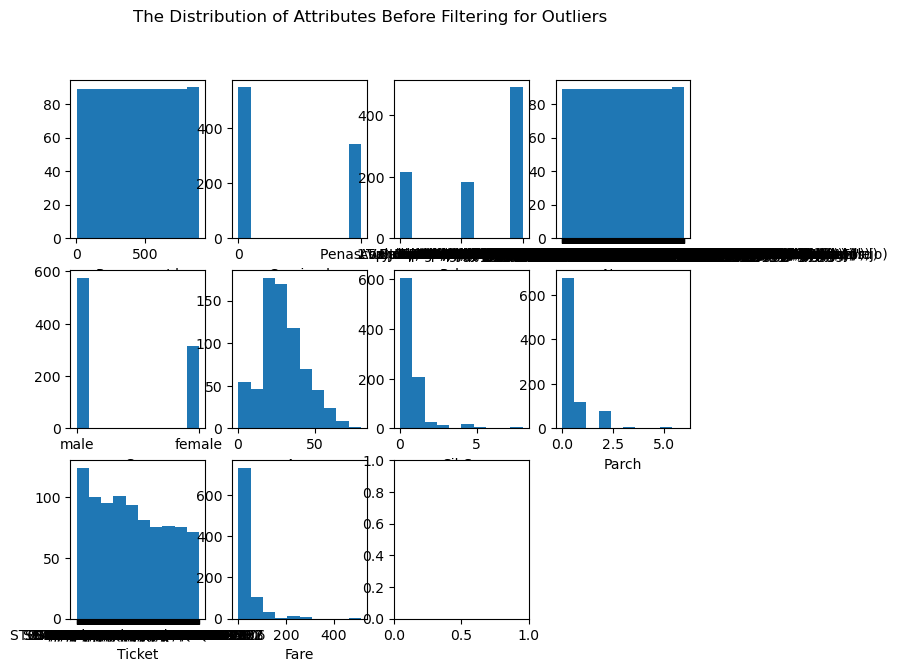

In [ ]:
M = (len(training_data.columns))
N = len(training_data)

plt.figure(figsize=(8, 7))
# units = ['mu U/ml','yrs','','','mm','kg/m^2','mmol/L','mm Hg','']
u = np.floor(np.sqrt(M))
v = np.ceil(float(M) / u)
limits = [600,600,600,300,300,300,400,400,400]
plt.suptitle('The Distribution of Attributes Before Filtering for Outliers')
print(M)
for i in range(M):

    plt.subplot(int(u), int(v), i + 1)
    plt.hist(training_data[columns[i]],bins=(2 if columns[i]=='Survived' else 10))
    plt.xlabel(columns[i])
    if columns[i]=='Survived':
        plt.xticks([0,1])

    # plt.ylim(0,limits[i])

plt.tight_layout()
plt.show()
